<a href="https://colab.research.google.com/github/Engineer-Gustavo-Softworks/TRATAMENTO-DE-DADOS-ATIVIDADE-11-E-12-INMET-BRASILIA-2009-/blob/main/METODOS_PARA_CURVA_DE_WEIBULL_BRASILIA_2009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Planilha Brasilia 2009_excel.xlsx to Planilha Brasilia 2009_excel.xlsx


In [2]:
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, weibull_min
from scipy.special import gamma
from scipy.optimize import fsolve
import math
from scipy.integrate import quad

df = pd.read_excel('Planilha Brasilia 2009_excel.xlsx', engine='openpyxl')

df_copia = df.copy (deep = True)
df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']] = df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']].replace(-9999,np.nan)

#De acordo com a distribuição do feature, decidi substituir os valores nulos por um método.
df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média

# Verificando a exitencia de valores duplicados:
df_copia.duplicated().sum()



<ipython-input-2-91b1340059e0>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média


np.int64(0)

,DATA (YYYY-MM-DD),HORA (UTC),"VENTO, VELOCIDADE HORARIA (m/s)"
0,2009-01-01,00:00:00,0.8
1,2009-01-01,01:00:00,1.3
2,2009-01-01,02:00:00,0.9
3,2009-01-01,03:00:00,1.1
4,2009-01-01,04:00:00,1.3


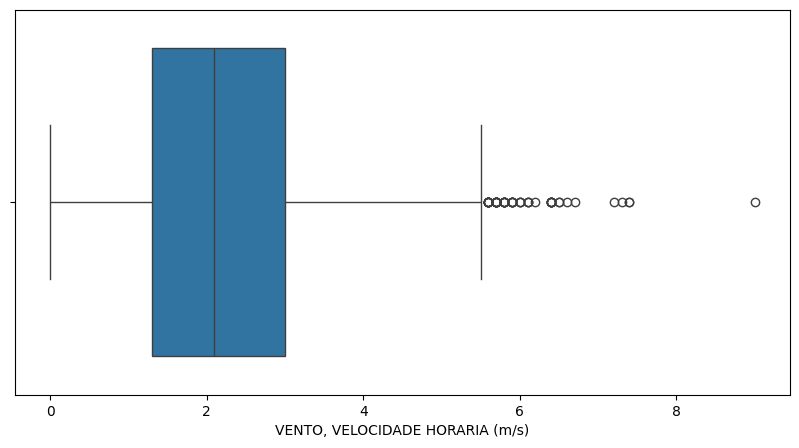

In [3]:
# Analisando a existencia de outleirs em 'VENTO, VELOCIDADE HORARIA (m/s)'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_copia['VENTO, VELOCIDADE HORARIA (m/s)'])

df_copia.describe()
df_copia.head()

In [4]:
df_copia.shape[0]
df_copia.describe()

,DATA (YYYY-MM-DD),"VENTO, VELOCIDADE HORARIA (m/s)"
count,8760,8760.000000
mean,2009-07-01 23:59:59.999999744,2.204109
min,2009-01-01 00:00:00,0.000000
25%,2009-04-02 00:00:00,1.300000
50%,2009-07-02 00:00:00,2.100000
75%,2009-10-01 00:00:00,3.000000
max,2009-12-31 00:00:00,9.000000
std,NaN,1.221206


> MÉTODOS PARA CURVA DE WEIBULL

In [5]:
import numpy as np
import pandas as pd
import math
from scipy.stats import linregress, weibull_min
from scipy.special import gamma
import scipy.integrate as integrate
import warnings

warnings.filterwarnings("ignore")

# ------- Carregar e tratar os dados ------- #
coluna = 'VENTO, VELOCIDADE HORARIA (m/s)'
dados = df_copia[coluna].dropna().sort_values().values
dados = dados[dados > 0]
n = len(dados)

# ------- Método da Energia Padrão ------- #
i = np.arange(1, n + 1)
F = (i - 0.3) / (n + 0.4)
ln_t = np.log(dados)
ln_ln = np.log(-np.log(1 - F))
slope, intercept, *_ = linregress(ln_t, ln_ln)
beta = slope
eta = np.exp(-intercept / beta)
print(f"[Energia Padrão] beta: {beta:.4f}, eta: {eta:.4f}")

# ------- Método dos Momentos ------- #
media = np.mean(dados)
variancia = np.var(dados)

def estimar_beta_mm(media, variancia):
    for b in np.linspace(0.5, 10, 10000):
        r = gamma(1 + 2/b) - (gamma(1 + 1/b))**2
        if np.isclose(r, variancia / media**2, atol=1e-4):
            return b
    return None

beta_mm = estimar_beta_mm(media, variancia)
eta_mm = media / gamma(1 + 1/beta_mm)
print(f"[Momentos] beta: {beta_mm:.4f}, eta: {eta_mm:.4f}")

# ------- Método da Máxima Verossimilhança ------- #
params = weibull_min.fit(dados, floc=0)
beta_mle, loc_mle, eta_mle = params
print(f"[Máxima Verossimilhança] beta: {beta_mle:.4f}, eta: {eta_mle:.4f}")

# ------- Função da Turbina com Cut-in de 3 m/s ------- #
def turbina_cutin_3ms(v):
    return v**3 if v >= 3 else 0

# ------- Tabela detalhada de produção por faixas - Multimétodo com integração v*f(v) ------- #
def weibull_pdf(v, k, c):
    return (k / c) * (v / c)**(k - 1) * np.exp(-(v / c)**k) if v > 0 else 0

def calcular_velocidade_media_integrada(u1, u2, k, c):
    num, _ = integrate.quad(lambda v: v * weibull_pdf(v, k, c), u1, u2)
    den, _ = integrate.quad(lambda v: weibull_pdf(v, k, c), u1, u2)
    return num / den if den > 0 else (u1 + u2) / 2

def tabela_producao_energia_integrada(bins, k_list, c_list, nomes_metodos, p_func=turbina_cutin_3ms):
    tabelas = {}
    intervalos = pd.IntervalIndex.from_breaks(bins)

    for k, c, nome_metodo in zip(k_list, c_list, nomes_metodos):
        faixas, probabilidades, velocidades_medias, potencias, energia_esperada = [], [], [], [], []

        for intervalo in intervalos:
            u1, u2 = intervalo.left, intervalo.right
            p = (math.exp(-(u1 / c) ** k) - math.exp(-(u2 / c) ** k)) * 100
            v_med = calcular_velocidade_media_integrada(u1, u2, k, c)
            pot = p_func(v_med)
            energia = p * pot / 100

            faixas.append(str(intervalo))
            probabilidades.append(round(p, 2))
            velocidades_medias.append(round(v_med, 2))
            potencias.append(round(pot, 2))
            energia_esperada.append(round(energia, 2))

        df = pd.DataFrame({
            'VENTO, VELOCIDADE HORARIA (m/s)': faixas,
            'Probabilidade (%)': probabilidades,
            'Vel. média (m/s)': velocidades_medias,
            'Potência (W)': potencias,
            'Prob. × Potência (W)': energia_esperada
        })

        # Cálculo da potência média e energia total esperada
        potencia_media = np.mean(potencias)
        energia_total = np.sum(energia_esperada)

        df.loc['MÉDIA/TOTAL'] = ['', '', '', round(potencia_media, 2), round(energia_total, 2)]

        tabelas[nome_metodo] = df

    return tabelas

# ------- Rayleigh ------- #
def rayleigh_pdf(v, c):
    return (v / c**2) * np.exp(-v**2 / (2 * c**2)) if v > 0 else 0

def calcular_velocidade_media_integrada_rayleigh(u1, u2, c):
    num, _ = integrate.quad(lambda v: v * rayleigh_pdf(v, c), u1, u2)
    den, _ = integrate.quad(lambda v: rayleigh_pdf(v, c), u1, u2)
    return num / den if den > 0 else (u1 + u2) / 2

def tabela_producao_rayleigh_integrada(bins, c_rayleigh, p_func=turbina_cutin_3ms):
    faixas, probabilidades, velocidades_medias, potencias, energia_esperada = [], [], [], [], []
    intervalos = pd.IntervalIndex.from_breaks(bins)

    for intervalo in intervalos:
        u1, u2 = intervalo.left, intervalo.right
        p = (np.exp(-u1**2 / (2 * c_rayleigh**2)) - np.exp(-u2**2 / (2 * c_rayleigh**2))) * 100
        v_med = calcular_velocidade_media_integrada_rayleigh(u1, u2, c_rayleigh)
        pot = p_func(v_med)
        energia = p * pot / 100

        faixas.append(str(intervalo))
        probabilidades.append(round(p, 2))
        velocidades_medias.append(round(v_med, 2))
        potencias.append(round(pot, 2))
        energia_esperada.append(round(energia, 2))

    df = pd.DataFrame({
        'VENTO, VELOCIDADE HORARIA (m/s)': faixas,
        'Probabilidade (%)': probabilidades,
        'Vel. média (m/s)': velocidades_medias,
        'Potência (W)': potencias,
        'Prob. × Potência (W)': energia_esperada
    })

    potencia_media = np.mean(potencias)
    energia_total = np.sum(energia_esperada)

    df.loc['MÉDIA/TOTAL'] = ['', '', '', round(potencia_media, 2), round(energia_total, 2)]

    return df

# ------- Parâmetros para geração das tabelas ------- #
bins = np.arange(0, 10, 1)

k_list = [beta, beta_mm, beta_mle]
c_list = [eta, eta_mm, eta_mle]
nomes_metodos = ['Energia Padrão', 'Momentos', 'Máxima Verossimilhança']

# Tabelas Weibull integradas
tabelas_energia = tabela_producao_energia_integrada(bins, k_list, c_list, nomes_metodos)

for metodo, tabela in tabelas_energia.items():
    print(f"\n=== Tabela de Produção de Energia - {metodo} ===")
    print(tabela.to_string())

# Rayleigh
media_real = np.mean(dados)
c_rayleigh = media_real * np.sqrt(2 / np.pi)

tabela_rayleigh = tabela_producao_rayleigh_integrada(bins, c_rayleigh)
print("\n=== Tabela de Produção de Energia - Rayleigh ===")
print(tabela_rayleigh.to_string())

[Energia Padrão] beta: 1.8838, eta: 2.5697
[Momentos] beta: 1.7551, eta: 2.5384
[Máxima Verossimilhança] beta: 1.9783, eta: 2.5459

=== Tabela de Produção de Energia - Energia Padrão ===
            VENTO, VELOCIDADE HORARIA (m/s) Probabilidade (%) Vel. média (m/s)  Potência (W)  Prob. × Potência (W)
0                                    (0, 1]             15.55             0.64          0.00                  0.00
1                                    (1, 2]             30.85             1.51          0.00                  0.00
2                                    (2, 3]             27.38             2.47          0.00                  0.00
3                                    (3, 4]             16.21             3.44         40.78                  6.61
4                                    (4, 5]               7.0             4.42         86.25                  6.04
5                                    (5, 6]              2.29              5.4        157.23                  3.60
6       

ATIVIDADE 11 - IMPLEMENTANDO A CURVA DE TORQUE DA TURBINA


=== Tabela de Produção de Energia e Torque - Energia Padrão ===
            VENTO, VELOCIDADE HORARIA (m/s) Probabilidade (%) Vel. média (m/s)  Potência (W)  Prob. × Potência (W)  Torque (Nm)
0                                    (0, 1]             15.55             0.64          0.00                  0.00         0.01
1                                    (1, 2]             30.85             1.51          0.00                  0.00         0.05
2                                    (2, 3]             27.38             2.47          0.00                  0.00         0.13
3                                    (3, 4]             16.21             3.44         40.78                  6.61         0.26
4                                    (4, 5]               7.0             4.42         86.25                  6.04         0.43
5                                    (5, 6]              2.29              5.4        157.23                  3.60         0.64
6                                    (6

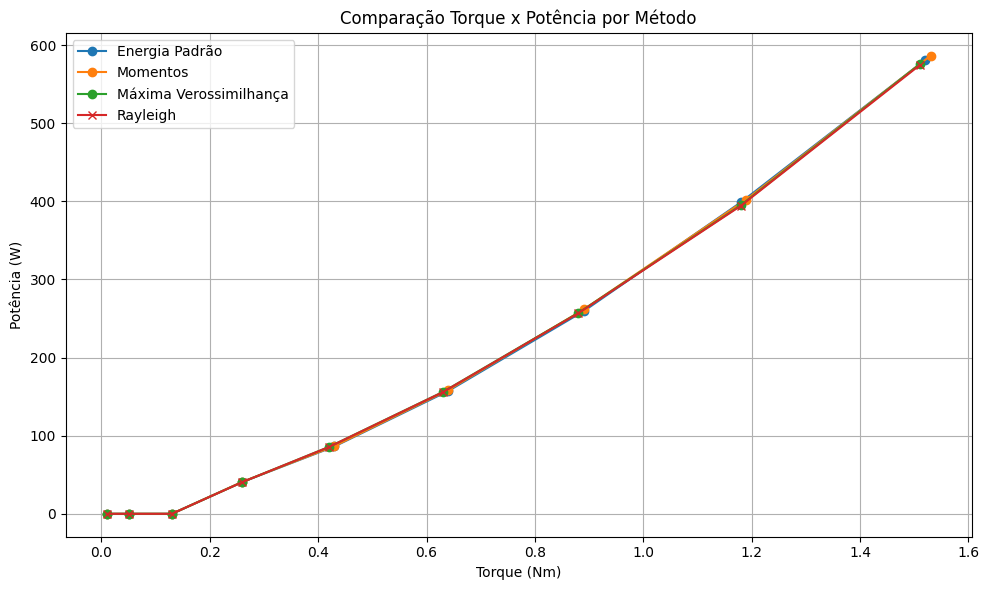

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import linregress, weibull_min
from scipy.special import gamma
import scipy.integrate as integrate
import warnings

warnings.filterwarnings("ignore")

# ------- Função para cálculo do torque ------- #
def calcular_torque(v, rho=1.225, A=78.54, D=10, theta=0.261799, lambd=1):
    Cp = 0.22 * ((116 / lambd) - 0.4 * theta - 5) * np.exp(-12.5 / lambd)
    Cq = Cp / 1
    Q = (Cq / 2) * (rho * A * (v ** 2) * D) / 2
    return Q

# ------- Função da Turbina com Cut-in de 3 m/s ------- #
def turbina_cutin_3ms(v):
    return v**3 if v >= 3 else 0

# ------- Weibull PDF ------- #
def weibull_pdf(v, k, c):
    return (k / c) * (v / c)**(k - 1) * np.exp(-(v / c)**k) if v > 0 else 0

# ------- Rayleigh PDF ------- #
def rayleigh_pdf(v, c):
    return (v / c**2) * np.exp(-v**2 / (2 * c**2)) if v > 0 else 0

# ------- Calcular velocidade média integrada ------- #
def calcular_velocidade_media_integrada(u1, u2, k, c):
    num, _ = integrate.quad(lambda v: v * weibull_pdf(v, k, c), u1, u2)
    den, _ = integrate.quad(lambda v: weibull_pdf(v, k, c), u1, u2)
    return num / den if den > 0 else (u1 + u2) / 2

def calcular_velocidade_media_integrada_rayleigh(u1, u2, c):
    num, _ = integrate.quad(lambda v: v * rayleigh_pdf(v, c), u1, u2)
    den, _ = integrate.quad(lambda v: rayleigh_pdf(v, c), u1, u2)
    return num / den if den > 0 else (u1 + u2) / 2

# ------- Tabela Weibull com Torque ------- #
def tabela_producao_energia_torque_integrada(bins, k_list, c_list, nomes_metodos, p_func=turbina_cutin_3ms):
    tabelas = {}
    intervalos = pd.IntervalIndex.from_breaks(bins)

    for k, c, nome_metodo in zip(k_list, c_list, nomes_metodos):
        faixas, probabilidades, velocidades_medias = [], [], []
        potencias, energia_esperada, torques = [], [], []

        for intervalo in intervalos:
            u1, u2 = intervalo.left, intervalo.right
            p = (math.exp(-(u1 / c) ** k) - math.exp(-(u2 / c) ** k)) * 100
            v_med = calcular_velocidade_media_integrada(u1, u2, k, c)
            pot = p_func(v_med)
            energia = p * pot / 100
            torque = calcular_torque(v_med)

            faixas.append(str(intervalo))
            probabilidades.append(round(p, 2))
            velocidades_medias.append(round(v_med, 2))
            potencias.append(round(pot, 2))
            energia_esperada.append(round(energia, 2))
            torques.append(round(torque, 2))

        df = pd.DataFrame({
            'VENTO, VELOCIDADE HORARIA (m/s)': faixas,
            'Probabilidade (%)': probabilidades,
            'Vel. média (m/s)': velocidades_medias,
            'Potência (W)': potencias,
            'Prob. × Potência (W)': energia_esperada,
            'Torque (Nm)': torques
        })

        potencia_media = np.mean(potencias)
        energia_total = np.sum(energia_esperada)
        torque_medio = np.mean(torques)

        df.loc['MÉDIA/TOTAL'] = ['', '', '', round(potencia_media, 2), round(energia_total, 2), round(torque_medio, 2)]

        tabelas[nome_metodo] = df

    return tabelas

# ------- Tabela Rayleigh com Torque ------- #
def tabela_producao_rayleigh_torque_integrada(bins, c_rayleigh, p_func=turbina_cutin_3ms):
    faixas, probabilidades, velocidades_medias = [], [], []
    potencias, energia_esperada, torques = [], [], []
    intervalos = pd.IntervalIndex.from_breaks(bins)

    for intervalo in intervalos:
        u1, u2 = intervalo.left, intervalo.right
        p = (np.exp(-u1**2 / (2 * c_rayleigh**2)) - np.exp(-u2**2 / (2 * c_rayleigh**2))) * 100
        v_med = calcular_velocidade_media_integrada_rayleigh(u1, u2, c_rayleigh)
        pot = p_func(v_med)
        energia = p * pot / 100
        torque = calcular_torque(v_med)

        faixas.append(str(intervalo))
        probabilidades.append(round(p, 2))
        velocidades_medias.append(round(v_med, 2))
        potencias.append(round(pot, 2))
        energia_esperada.append(round(energia, 2))
        torques.append(round(torque, 2))

    df = pd.DataFrame({
        'VENTO, VELOCIDADE HORARIA (m/s)': faixas,
        'Probabilidade (%)': probabilidades,
        'Vel. média (m/s)': velocidades_medias,
        'Potência (W)': potencias,
        'Prob. × Potência (W)': energia_esperada,
        'Torque (Nm)': torques
    })

    potencia_media = np.mean(potencias)
    energia_total = np.sum(energia_esperada)
    torque_medio = np.mean(torques)

    df.loc['MÉDIA/TOTAL'] = ['', '', '', round(potencia_media, 2), round(energia_total, 2), round(torque_medio, 2)]

    return df

# ------- Ajuste Weibull com 3 métodos ------- #
coluna = 'VENTO, VELOCIDADE HORARIA (m/s)'
dados = df_copia[coluna].dropna().sort_values().values
dados = dados[dados > 0]
n = len(dados)

# Energia Padrão
i = np.arange(1, n + 1)
F = (i - 0.3) / (n + 0.4)
ln_t = np.log(dados)
ln_ln = np.log(-np.log(1 - F))
slope, intercept, *_ = linregress(ln_t, ln_ln)
beta = slope
eta = np.exp(-intercept / beta)

# Momentos
media = np.mean(dados)
variancia = np.var(dados)
def estimar_beta_mm(media, variancia):
    for b in np.linspace(0.5, 10, 10000):
        r = gamma(1 + 2/b) - (gamma(1 + 1/b))**2
        if np.isclose(r, variancia / media**2, atol=1e-4):
            return b
    return None
beta_mm = estimar_beta_mm(media, variancia)
eta_mm = media / gamma(1 + 1/beta_mm)

# Máxima Verossimilhança
params = weibull_min.fit(dados, floc=0)
beta_mle, loc_mle, eta_mle = params

# Rayleigh
media_real = np.mean(dados)
c_rayleigh = media_real * np.sqrt(2 / np.pi)

# ------- Parâmetros ------- #
bins = np.arange(0, 10, 1)
k_list = [beta, beta_mm, beta_mle]
c_list = [eta, eta_mm, eta_mle]
nomes_metodos = ['Energia Padrão', 'Momentos', 'Máxima Verossimilhança']

# ------- Tabelas com Torque ------- #
tabelas_energia_torque = tabela_producao_energia_torque_integrada(bins, k_list, c_list, nomes_metodos)
tabela_rayleigh_torque = tabela_producao_rayleigh_torque_integrada(bins, c_rayleigh)

# ------- Impressão ------- #
for metodo, tabela in tabelas_energia_torque.items():
    print(f"\n=== Tabela de Produção de Energia e Torque - {metodo} ===")
    print(tabela.to_string())

print("\n=== Tabela de Produção de Energia e Torque - Rayleigh ===")
print(tabela_rayleigh_torque.to_string())

# ------- Gráfico Torque x Potência ------- #
plt.figure(figsize=(10,6))

for metodo, tabela in tabelas_energia_torque.items():
    potencias = tabela['Potência (W)'][:-1]
    torques = tabela['Torque (Nm)'][:-1]
    plt.plot(torques, potencias, marker='o', label=metodo)

potencias_rayleigh = tabela_rayleigh_torque['Potência (W)'][:-1]
torques_rayleigh = tabela_rayleigh_torque['Torque (Nm)'][:-1]
plt.plot(torques_rayleigh, potencias_rayleigh, marker='x', label='Rayleigh')

plt.xlabel('Torque (Nm)')
plt.ylabel('Potência (W)')
plt.title('Comparação Torque x Potência por Método')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Tabela de Produção de Energia e Torque - Energia Padrão ===
            VENTO, VELOCIDADE HORARIA (m/s) Probabilidade (%) Vel. média (m/s)  Potência (W)  Prob. × Potência (W)  Torque (Nm)
0                                    (0, 1]             15.55             0.64          0.00                  0.00         0.01
1                                    (1, 2]             30.85             1.51          0.00                  0.00         0.05
2                                    (2, 3]             27.38             2.47          0.00                  0.00         0.13
3                                    (3, 4]             16.21             3.44         40.78                  6.61         0.26
4                                    (4, 5]               7.0             4.42         86.25                  6.04         0.43
5                                    (5, 6]              2.29              5.4        157.23                  3.60         0.64
6                                    (6

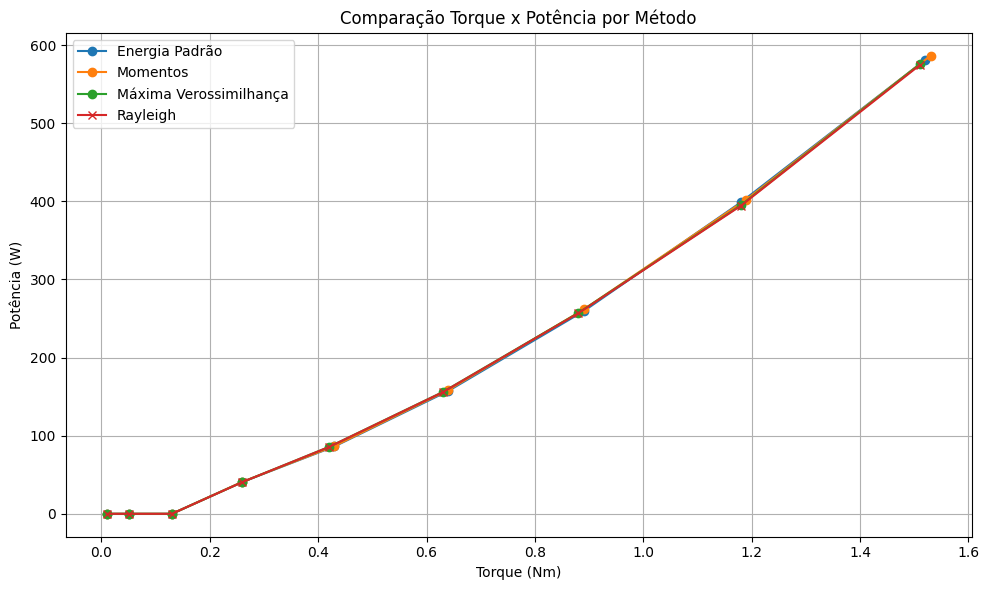

In [7]:
def tabela_producao_energia_torque_integrada(bins, k_list, c_list, nomes_metodos, p_func=turbina_cutin_3ms):
    tabelas = {}
    intervalos = pd.IntervalIndex.from_breaks(bins)

    for k, c, nome_metodo in zip(k_list, c_list, nomes_metodos):
        # Initialize the lists outside the inner loop
        faixas, probabilidades, velocidades_medias = [], [], []
        potencias, energia_esperada, torques = [], [], []

        for intervalo in intervalos:
            u1, u2 = intervalo.left, intervalo.right
            p = (math.exp(-(u1 / c) ** k) - math.exp(-(u2 / c) ** k)) * 100
            v_med = calcular_velocidade_media_integrada(u1, u2, k, c)
            pot = p_func(v_med)
            energia = p * pot / 100
            torque = calcular_torque(v_med)

            # Append the calculated values to the lists
            faixas.append(str(intervalo))
            probabilidades.append(round(p, 2))
            velocidades_medias.append(round(v_med, 2))
            potencias.append(round(pot, 2))
            energia_esperada.append(round(energia, 2))
            torques.append(round(torque, 2))

        # Create the DataFrame outside the inner loop, after all intervals are processed
        df = pd.DataFrame({
            'VENTO, VELOCIDADE HORARIA (m/s)': faixas,
            'Probabilidade (%)': probabilidades,
            'Vel. média (m/s)': velocidades_medias,
            'Potência (W)': potencias,
            'Prob. × Potência (W)': energia_esperada,
            'Torque (Nm)': torques
        })

        # Cálculo da potência média e energia total esperada
        potencia_media = np.mean(potencias)
        energia_total = np.sum(energia_esperada)
        torque_medio = np.mean(torques)

        df.loc['MÉDIA/TOTAL'] = ['', '', '', round(potencia_media, 2), round(energia_total, 2), round(torque_medio, 2)]

        tabelas[nome_metodo] = df

    return tabelas

# The rest of your code remains the same

def tabela_producao_rayleigh_torque_integrada(bins, c_rayleigh, p_func=turbina_cutin_3ms):
    faixas, probabilidades, velocidades_medias = [], [], []
    potencias, energia_esperada, torques = [], [], []
    intervalos = pd.IntervalIndex.from_breaks(bins)

    for intervalo in intervalos:
        u1, u2 = intervalo.left, intervalo.right
        p = (np.exp(-u1**2 / (2 * c_rayleigh**2)) - np.exp(-u2**2 / (2 * c_rayleigh**2))) * 100
        v_med = calcular_velocidade_media_integrada_rayleigh(u1, u2, c_rayleigh)
        pot = p_func(v_med)
        energia = p * pot / 100
        torque = calcular_torque(v_med)

        faixas.append(str(intervalo))
        probabilidades.append(round(p, 2))
        velocidades_medias.append(round(v_med, 2))
        potencias.append(round(pot, 2))
        energia_esperada.append(round(energia, 2))
        torques.append(round(torque, 2))

    df = pd.DataFrame({
        'VENTO, VELOCIDADE HORARIA (m/s)': faixas,
        'Probabilidade (%)': probabilidades,
        'Vel. média (m/s)': velocidades_medias,
        'Potência (W)': potencias,
        'Prob. × Potência (W)': energia_esperada,
        'Torque (Nm)': torques
    })

    potencia_media = np.mean(potencias)
    energia_total = np.sum(energia_esperada)
    torque_medio = np.mean(torques)

    df.loc['MÉDIA/TOTAL'] = ['', '', '', round(potencia_media, 2), round(energia_total, 2), round(torque_medio, 2)]

    return df

tabelas_energia_torque = tabela_producao_energia_torque_integrada(bins, k_list, c_list, nomes_metodos)

for metodo, tabela in tabelas_energia_torque.items():
    print(f"\n=== Tabela de Produção de Energia e Torque - {metodo} ===")
    print(tabela.to_string())

tabela_rayleigh_torque = tabela_producao_rayleigh_torque_integrada(bins, c_rayleigh)
print("\n=== Tabela de Produção de Energia e Torque - Rayleigh ===")
print(tabela_rayleigh_torque.to_string())


import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for metodo, tabela in tabelas_energia_torque.items():
    potencias = tabela['Potência (W)'][:-1]  # Exclui linha MÉDIA/TOTAL
    torques = tabela['Torque (Nm)'][:-1]
    plt.plot(torques, potencias, marker='o', label=metodo)

# Rayleigh
potencias_rayleigh = tabela_rayleigh_torque['Potência (W)'][:-1]
torques_rayleigh = tabela_rayleigh_torque['Torque (Nm)'][:-1]
plt.plot(torques_rayleigh, potencias_rayleigh, marker='x', label='Rayleigh')

plt.xlabel('Torque (Nm)')
plt.ylabel('Potência (W)')
plt.title('Comparação Torque x Potência por Método')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


ATIVIDADE 12 - COMPARANDO A POTÊNCIA GERADA POR DOIS TIPOS DE TURBINAS

[Energia Padrão] beta: 1.8838, eta: 2.5697

=== Tabela Comparativa de Potência - Método Energia Padrão ===
Faixa de Velocidade (m/s)  Vel. Média Integrada (m/s)  Potência Freen-H20 (W)  Potência Freen-20 (W)
                      0-1                        0.64                    0.00                   0.00
                      1-2                        1.51                    0.00                   0.00
                      2-3                        2.47                    0.00                   0.00
                      3-4                        3.44                    2.37                   0.00
                      4-5                        4.42                   78.27                  56.40
                      5-6                        5.40                  378.01                 497.44
                      6-7                        6.38                 1057.75                1736.52
                      7-8                        7.36                 2274.78        

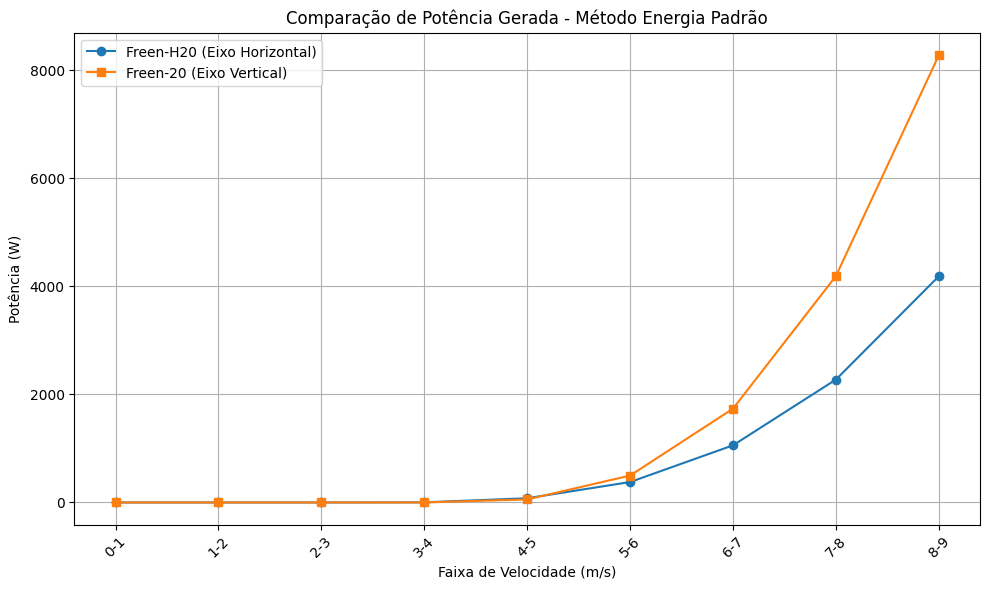

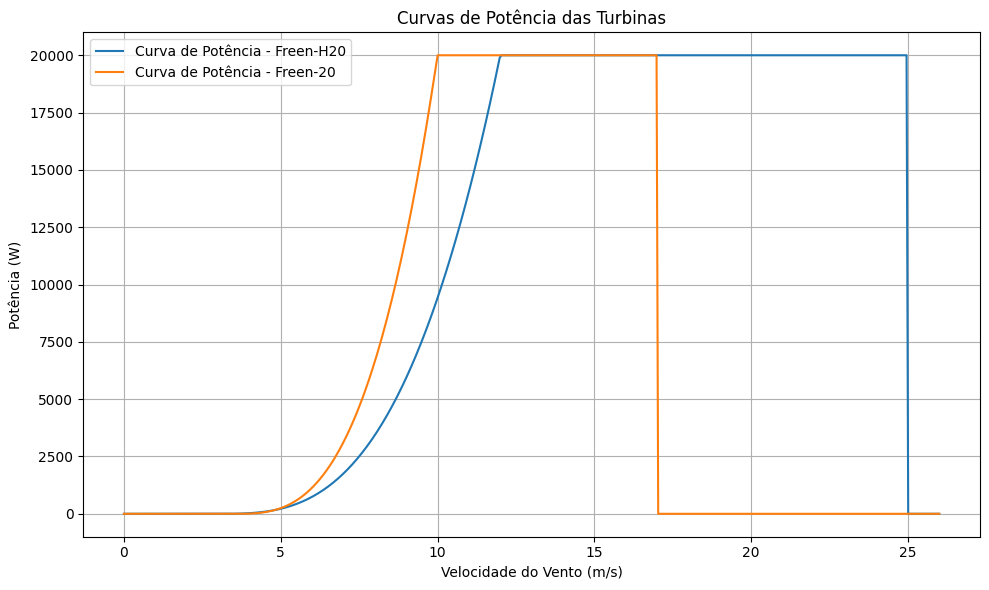

In [14]:
import numpy as np
import pandas as pd
import math
from scipy.stats import linregress
from scipy.special import gamma
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ------- Carregar e tratar os dados ------- #
coluna = 'VENTO, VELOCIDADE HORARIA (m/s)'
dados = df_copia[coluna].dropna().sort_values().values
dados = dados[dados > 0]
n = len(dados)

# ------- Método da Energia Padrão ------- #
i = np.arange(1, n + 1)
F = (i - 0.3) / (n + 0.4)
ln_t = np.log(dados)
ln_ln = np.log(-np.log(1 - F))
slope, intercept, *_ = linregress(ln_t, ln_ln)
beta = slope
eta = np.exp(-intercept / beta)
print(f"[Energia Padrão] beta: {beta:.4f}, eta: {eta:.4f}")

# ------- Funções das Turbinas ------- #
# Freen-H20 (Eixo Horizontal)
def freen_h20_potencia(v):
    # Características típicas
    v_cut_in = 3  # m/s
    v_rated = 12  # m/s
    v_cut_off = 25  # m/s
    p_rated = 20000  # W

    if v < v_cut_in or v > v_cut_off:
        return 0
    elif v <= v_rated:
        return p_rated * ((v - v_cut_in) / (v_rated - v_cut_in))**3
    else:
        return p_rated

# Freen-20 (Eixo Vertical)
def freen_20_potencia(v):
    v_cut_in = 3.5  # m/s
    v_rated = 10  # m/s
    v_cut_off = 17  # m/s
    p_rated = 20000  # W

    if v < v_cut_in or v > v_cut_off:
        return 0
    elif v <= v_rated:
        return p_rated * ((v - v_cut_in) / (v_rated - v_cut_in))**3
    else:
        return p_rated

# ------- Função Weibull PDF ------- #
def weibull_pdf(v, k, c):
    return (k / c) * (v / c)**(k - 1) * np.exp(-(v / c)**k) if v > 0 else 0

# ------- Cálculo de Velocidade Média Integrada ------- #
def calcular_velocidade_media_integrada(u1, u2, k, c):
    num, _ = integrate.quad(lambda v: v * weibull_pdf(v, k, c), u1, u2)
    den, _ = integrate.quad(lambda v: weibull_pdf(v, k, c), u1, u2)
    return num / den if den > 0 else (u1 + u2) / 2

# ------- Tabela para duas turbinas e gráfico comparativo ------- #
bins = np.arange(0, 10, 1)
intervalos = pd.IntervalIndex.from_breaks(bins)

faixas = []
velocidades_medias = []
potencias_freen_h20 = []
potencias_freen_20 = []

for intervalo in intervalos:
    u1, u2 = intervalo.left, intervalo.right
    v_med = calcular_velocidade_media_integrada(u1, u2, beta, eta)

    pot_h20 = freen_h20_potencia(v_med)
    pot_20 = freen_20_potencia(v_med)

    faixas.append(f"{u1}-{u2}")
    velocidades_medias.append(v_med)
    potencias_freen_h20.append(pot_h20)
    potencias_freen_20.append(pot_20)

# ------- DataFrame comparativo ------- #
df_comparativo = pd.DataFrame({
    'Faixa de Velocidade (m/s)': faixas,
    'Vel. Média Integrada (m/s)': np.round(velocidades_medias, 2),
    'Potência Freen-H20 (W)': np.round(potencias_freen_h20, 2),
    'Potência Freen-20 (W)': np.round(potencias_freen_20, 2)
})

print("\n=== Tabela Comparativa de Potência - Método Energia Padrão ===")
print(df_comparativo.to_string(index=False))

# ------- Gráfico comparativo de potência gerada ------- #
plt.figure(figsize=(10,6))
x = np.arange(len(faixas))

plt.plot(x, potencias_freen_h20, marker='o', label='Freen-H20 (Eixo Horizontal)')
plt.plot(x, potencias_freen_20, marker='s', label='Freen-20 (Eixo Vertical)')

plt.xticks(x, faixas, rotation=45)
plt.xlabel('Faixa de Velocidade (m/s)')
plt.ylabel('Potência (W)')
plt.title('Comparação de Potência Gerada - Método Energia Padrão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------- Gráfico da curva de potência das turbinas ------- #
v_range = np.linspace(0, 26, 500)
pot_h20_curve = [freen_h20_potencia(v) for v in v_range]
pot_20_curve = [freen_20_potencia(v) for v in v_range]

plt.figure(figsize=(10,6))
plt.plot(v_range, pot_h20_curve, label='Curva de Potência - Freen-H20')
plt.plot(v_range, pot_20_curve, label='Curva de Potência - Freen-20')

plt.xlabel('Velocidade do Vento (m/s)')
plt.ylabel('Potência (W)')
plt.title('Curvas de Potência das Turbinas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[Energia Padrão] beta: 1.8838, eta: 2.5697

=== Frequência Relativa da Potência - Método Energia Padrão ===
Faixa de Velocidade (m/s)  Vel. Média Integrada (m/s)  Frequência Relativa (%)  Freq. × Pot. Turbina 3 m/s (W)  Freq. × Pot. Turbina 2 m/s (W)
                      0-1                        0.64                    15.55                            0.00                            0.00
                      1-2                        1.51                    30.85                            0.00                            0.00
                      2-3                        2.47                    27.38                            0.00                            4.13
                      3-4                        3.44                    16.21                            6.61                            6.61
                      4-5                        4.42                     7.00                            6.04                            6.04
                      5-6         

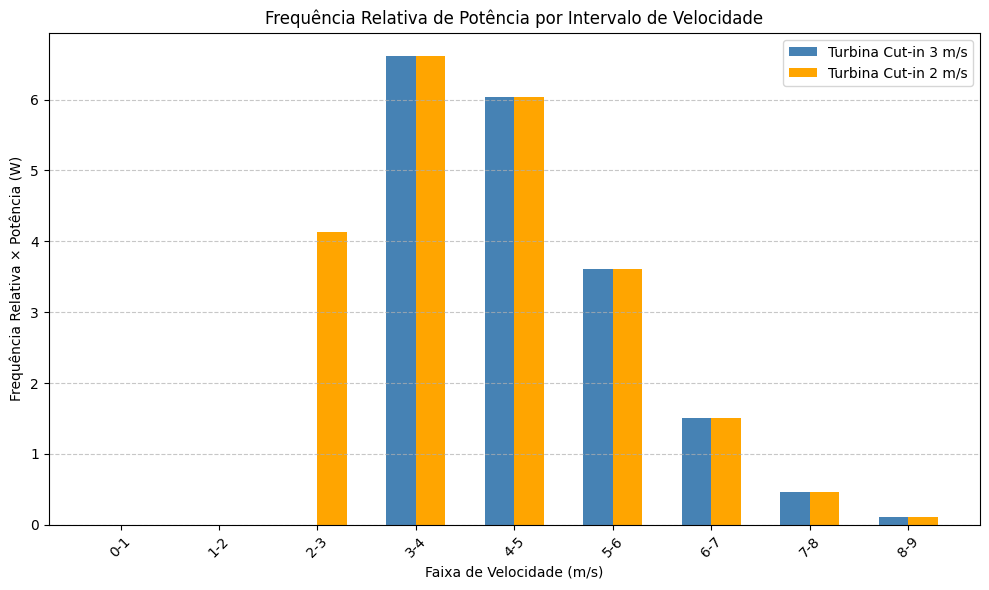

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.stats import linregress
from scipy.special import gamma
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ------- Carregar e tratar os dados ------- #
coluna = 'VENTO, VELOCIDADE HORARIA (m/s)'
dados = df_copia[coluna].dropna().sort_values().values
dados = dados[dados > 0]
n = len(dados)

# ------- Método da Energia Padrão ------- #
i = np.arange(1, n + 1)
F = (i - 0.3) / (n + 0.4)
ln_t = np.log(dados)
ln_ln = np.log(-np.log(1 - F))
slope, intercept, *_ = linregress(ln_t, ln_ln)
beta = slope
eta = np.exp(-intercept / beta)
print(f"[Energia Padrão] beta: {beta:.4f}, eta: {eta:.4f}")

# ------- Funções das Turbinas ------- #
def turbina_cutin_3ms(v):
    return v**3 if v >= 3 else 0

def turbina_cutin_2ms(v):
    return v**3 if v >= 2 else 0

# ------- Função Weibull PDF ------- #
def weibull_pdf(v, k, c):
    return (k / c) * (v / c)**(k - 1) * np.exp(-(v / c)**k) if v > 0 else 0

# ------- Cálculo de Velocidade Média Integrada ------- #
def calcular_velocidade_media_integrada(u1, u2, k, c):
    num, _ = integrate.quad(lambda v: v * weibull_pdf(v, k, c), u1, u2)
    den, _ = integrate.quad(lambda v: weibull_pdf(v, k, c), u1, u2)
    return num / den if den > 0 else (u1 + u2) / 2

# ------- Cálculo da frequência relativa de potência ------- #
bins = np.arange(0, 10, 1)
intervalos = pd.IntervalIndex.from_breaks(bins)

faixas = []
velocidades_medias = []
frequencias = []
freq_pot_turbina1 = []
freq_pot_turbina2 = []

for intervalo in intervalos:
    u1, u2 = intervalo.left, intervalo.right
    # Frequência relativa (probabilidade em %)
    p = (math.exp(-(u1 / eta) ** beta) - math.exp(-(u2 / eta) ** beta)) * 100
    v_med = calcular_velocidade_media_integrada(u1, u2, beta, eta)

    pot1 = turbina_cutin_3ms(v_med)
    pot2 = turbina_cutin_2ms(v_med)

    # Frequência relativa da potência
    freq_pot1 = (p / 100) * pot1
    freq_pot2 = (p / 100) * pot2

    faixas.append(f"{u1}-{u2}")
    velocidades_medias.append(v_med)
    frequencias.append(p)
    freq_pot_turbina1.append(freq_pot1)
    freq_pot_turbina2.append(freq_pot2)

# ------- DataFrame comparativo ------- #
df_freq_pot = pd.DataFrame({
    'Faixa de Velocidade (m/s)': faixas,
    'Vel. Média Integrada (m/s)': np.round(velocidades_medias, 2),
    'Frequência Relativa (%)': np.round(frequencias, 2),
    'Freq. × Pot. Turbina 3 m/s (W)': np.round(freq_pot_turbina1, 2),
    'Freq. × Pot. Turbina 2 m/s (W)': np.round(freq_pot_turbina2, 2)
})

print("\n=== Frequência Relativa da Potência - Método Energia Padrão ===")
print(df_freq_pot.to_string(index=False))

# ------- Gráfico comparativo ------- #
plt.figure(figsize=(10,6))
x = np.arange(len(faixas))

plt.bar(x - 0.15, freq_pot_turbina1, width=0.3, label='Turbina Cut-in 3 m/s', color='steelblue')
plt.bar(x + 0.15, freq_pot_turbina2, width=0.3, label='Turbina Cut-in 2 m/s', color='orange')

plt.xticks(x, faixas, rotation=45)
plt.xlabel('Faixa de Velocidade (m/s)')
plt.ylabel('Frequência Relativa × Potência (W)')
plt.title('Frequência Relativa de Potência por Intervalo de Velocidade')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

ATIVIDADE 8 - CURVA DE POTÊNCIA PARA CADA MÉTODO

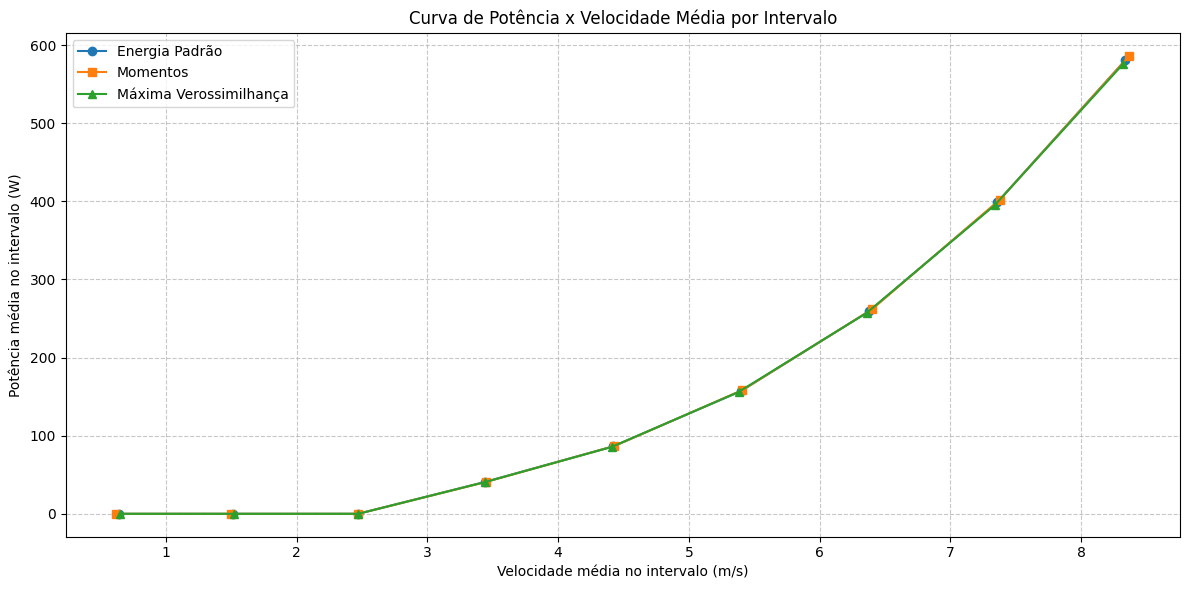

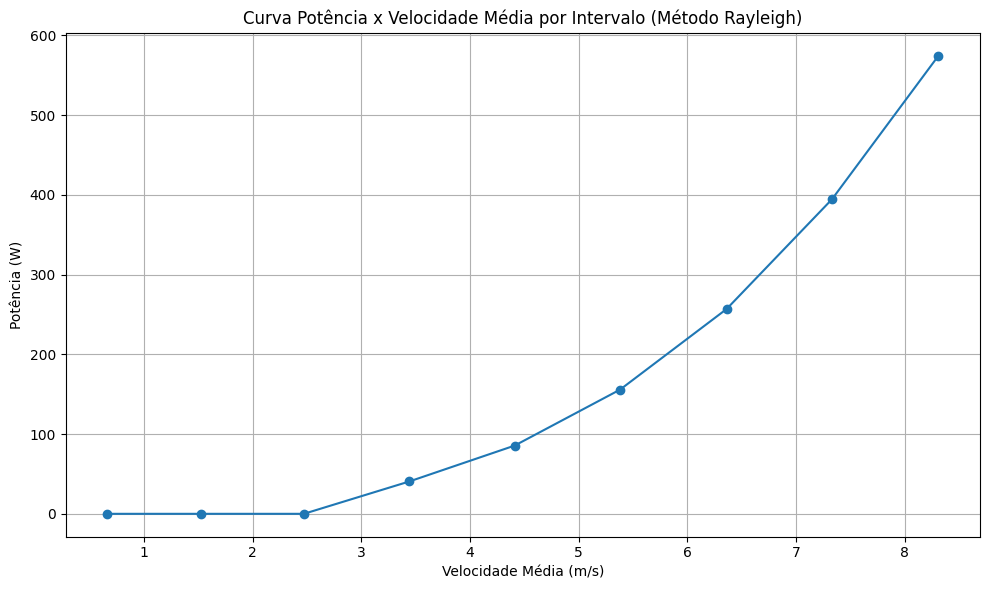

In [ ]:
plt.figure(figsize=(12, 6))

# EP
# Access the DataFrame for 'Energia Padrão' from the dictionary and exclude the last row
tabela_MEP = tabelas_energia['Energia Padrão'].iloc[:-1]
plt.plot(tabela_MEP['Vel. média (m/s)'], tabela_MEP['Potência (W)'],
         marker='o', label='Energia Padrão')

# MM
# Access the DataFrame for 'Momentos' from the dictionary and exclude the last row
tabela_MM = tabelas_energia['Momentos'].iloc[:-1]
plt.plot(tabela_MM['Vel. média (m/s)'], tabela_MM['Potência (W)'],
         marker='s', label='Momentos')

# MLE
# Access the DataFrame for 'Máxima Verossimilhança' from the dictionary and exclude the last row
tabela_MMV = tabelas_energia['Máxima Verossimilhança'].iloc[:-1]
plt.plot(tabela_MMV['Vel. média (m/s)'], tabela_MMV['Potência (W)'],
         marker='^', label='Máxima Verossimilhança')

# Estética
plt.title('Curva de Potência x Velocidade Média por Intervalo')
plt.xlabel('Velocidade média no intervalo (m/s)')
plt.ylabel('Potência média no intervalo (W)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
# Exclude the last row from the Rayleigh table before plotting
tabela_rayleigh_plot = tabela_rayleigh.iloc[:-1]
plt.plot(tabela_rayleigh_plot['Vel. média (m/s)'], tabela_rayleigh_plot['Potência (W)'], marker='o', linestyle='-')
plt.title('Curva Potência x Velocidade Média por Intervalo (Método Rayleigh)')
plt.xlabel('Velocidade Média (m/s)')
plt.ylabel('Potência (W)')
plt.grid(True)
plt.tight_layout()
plt.show()